# Logistic Regression with a Neural Network mindset

Welcome to your first (required) programming assignment! You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
# 使用imageio替代已弃用的scipy.ndimage.imread
import imageio
from PIL import Image
# from scipy import ndimage
from skimage.transform import resize  # 需要安装scikit-image包
%matplotlib inline

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [65]:
def load_train_dataset():
    """
    从 HDF5 文件中加载训练数据集。

    该函数读取存储在 'datasets/train_catvnoncat.h5' 文件中的训练集特征、标签和类别列表。

    返回：
        train_set_x (numpy.ndarray): 训练集特征，形状为 (num_samples, height, width, channels)。
        train_set_y (numpy.ndarray): 训练集标签，形状为 (1, num_samples)，包含每个样本的类别标签。
        train_set_classes (numpy.ndarray): 类别列表，形状为 (num_classes,)，包含所有可能的类别名称。
    """

    # 打开 HDF5 文件，读取训练数据集
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")

    # 获取训练集特征（图像数据），并转换为 NumPy 数组
    train_set_x = np.array(train_dataset.get('train_set_x')[:])

    # 获取训练集标签，转换为 NumPy 数组
    train_set_y = np.array(train_dataset.get('train_set_y')[:])

    # 将标签数组的形状调整为 (1, 样本数)，以便与模型的输入格式一致
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))

    # 获取类别列表，并转换为 NumPy 数组
    train_set_classes = np.array(train_dataset.get('list_classes')[:])

    # 返回训练集特征、训练集标签和类别列表
    return train_set_x, train_set_y, train_set_classes

In [66]:
train_set_x, train_set_y, train_set_classes = load_train_dataset()
print(f"train_set_x.shape:{train_set_x.shape}", f"train_set_y.shape:{train_set_y.shape}", f"train_set_classes.shape:{train_set_classes.shape}")

train_set_x.shape:(209, 64, 64, 3) train_set_y.shape:(1, 209) train_set_classes.shape:(2,)


In [67]:
print(train_set_classes[0].decode("utf-8"))
print(train_set_classes[1].decode("utf-8"))

non-cat
cat


y = [1], it's a 'cat' picture.


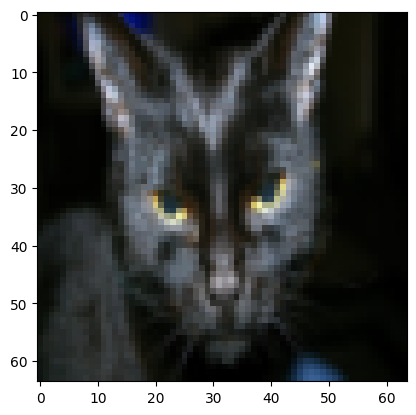

In [68]:
# Example of a picture
index = 25
plt.imshow(train_set_x[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + train_set_classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [69]:
def load_test_dataset():
    """
    从 HDF5 文件中加载测试数据集。

    该函数读取存储在 'datasets/test_catvnoncat.h5' 文件中的测试集特征、标签和类别列表。

    返回：
        test_set_x (numpy.ndarray): 测试集特征，形状为 (num_samples, height, width, channels)。
        test_set_y (numpy.ndarray): 测试集标签，形状为 (num_samples,)，包含每个样本的类别标签。
        test_set_classes (numpy.ndarray): 类别列表，形状为 (num_classes,)，包含所有可能的类别名称。
    """

    # 打开 HDF5 文件，读取测试数据集
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")

    # 获取测试集特征（图像数据），并转换为 NumPy 数组
    test_set_x = np.array(test_dataset.get('test_set_x')[:])

    # 获取测试集标签，转换为 NumPy 数组
    test_set_y = np.array(test_dataset.get('test_set_y')[:])
    # 将标签数组的形状调整为 (1, 样本数)，以便与模型的输入格式一致
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    # 获取类别列表，并转换为 NumPy 数组
    test_set_classes = np.array(test_dataset.get('list_classes')[:])

    # 返回测试集特征、测试集标签和类别列表
    return test_set_x, test_set_y, test_set_classes

In [70]:
test_set_x, test_set_y, test_set_classes = load_test_dataset()
print(f"test_set_x.shape:{test_set_x.shape}", f"test_set_y.shape:{test_set_y.shape}", f"test_set_classes.shape:{test_set_classes.shape}")

test_set_x.shape:(50, 64, 64, 3) test_set_y.shape:(1, 50) test_set_classes.shape:(2,)


In [71]:
print(test_set_classes[0].decode("utf-8"))
print(test_set_classes[1].decode("utf-8"))

non-cat
cat


y = [1], it's a 'cat' picture.


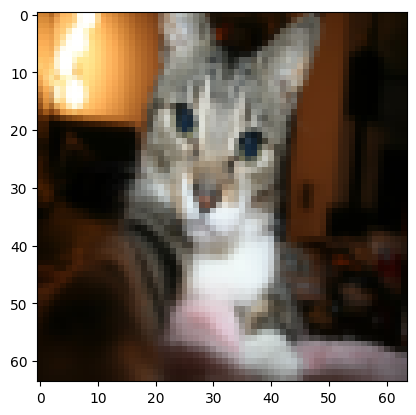

In [72]:
# Example of a picture
index = 25
plt.imshow(test_set_x[index])
print ("y = " + str(test_set_y[:, index]) + ", it's a '" + test_set_classes[np.squeeze(test_set_y[:, index])].decode("utf-8") +  "' picture.")

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images.

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [73]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x.shape[0]
m_test = test_set_x.shape[0]
num_px = train_set_x.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [74]:
# Reshape the training and test examples
# 将图像3维矩阵合并成而维矩阵
# (n, m) n行m列,其中m代表样本数量，n代表每个样本的特征数量
# 每一列代表一个完整的样本
### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0], -1).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0], -1).T
### END CODE HERE ###
print (f"train_set_x_flatten shape: {train_set_x_flatten.shape}")
print (f"train_set_y shape: {train_set_y.shape}")
print (f"test_set_x_flatten shape: {test_set_x_flatten.shape}")
print (f"test_set_y shape: {test_set_y.shape}")
print (f"sanity check after reshaping: {train_set_x_flatten[0:5,0]}")

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [75]:
# 归一化处理
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions. Use np.exp().

In [76]:
# GRADED FUNCTION: sigmoid
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1.0 / (1.0 + np.exp(-1.0 * z))
    ### END CODE HERE ###
    
    return s

In [77]:
print (f"sigmoid([0, 2]) = {sigmoid(np.array([0,2]))}")

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [78]:
# GRADED FUNCTION: initialize_with_zeros
def initialize_with_zeros(dim):
    """
    初始化权重 W 和偏置 b 为零。

    参数：
    dim (int): 特征的维度。它决定了权重 W 的行数，列数固定为 1。

    返回：
    tuple: 返回一个包含两个元素的元组：
        - W (numpy.ndarray): 一个形状为 (dim, 1) 的数组，表示初始化的权重，所有元素均为零。
        - b (int): 初始化的偏置，设置为零。
    """
    # 根据实际输入的特征的维度(dim)，初始化W 的维度为(dim, 1)
    W = np.zeros((dim, 1))
    b = 0
    assert(W.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return W, b

In [79]:
dim = train_set_x.shape[0]
W, b = initialize_with_zeros(dim)
print(f"W.shape = {W.shape}", f"b = {b}")

W.shape = (12288, 1) b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w.shape **  </td>
        <td> (1288, 1)
    </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$
- You calculate the cost function using matrix $J = -\frac{1}{m} \left( \mathbf{Y}^T \log ({\mathbf{A}}) + (1 - \mathbf{Y})^T \log(1 - {\mathbf{A}}) \right)$
- Here are the two formulas you will be using:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$
$$
   \frac{\partial J}{\partial b} = \frac{1}{m} \mathbf{1}^T (\mathbf{\hat{y}} - \mathbf{y}) \tag{9}
$$

In [80]:
def compute_cost(X, Y, W, b):
    """
    计算逻辑回归的成本函数。

    参数：
    W (numpy.ndarray): 权重向量，形状为 (n, 1)，其中 n 是特征的数量。
    b (float): 偏置项，标量值。
    X (numpy.ndarray): 特征矩阵，形状为 (n, m)，其中 n 是特征的数量，m 是样本的数量。
    Y (numpy.ndarray): 标签向量，形状为 (1, m)，每个元素为 0 或 1，表示样本的真实标签。

    返回：
    float: 计算得到的成本值，标量，表示模型预测与实际标签之间的差距。
    """
    m = X.shape[1]
    # 计算线性组合 Z = W^T @ X + b
    # (1, n) @ (n, m) => (1, m)
    Z = W.T @ X + b
    # 计算激活值 A = σ(Z)
    # (1, m)
    A = sigmoid(Z)
    # 计算成本, 注意这里需要得到一个标量,由于Y向量是以列的形式存在，这个地方需要变换
    # 当Y是列向量如(m, 1)时使用Y.T@np.log(A),当Y是行向量(1, m)的时候np.log(A) @ Y.T
    return (-1 / m) * (np.log(A) @ Y.T + np.log(1 - A) @ (1 - Y).T)

In [81]:
W, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])

In [82]:
W.shape

(2, 1)

In [83]:
X.shape

(2, 3)

In [84]:
Y.shape

(1, 3)

In [85]:
cost = compute_cost(X, Y, W, b)
# print(W, b, X, Y)
print(f"cost = {np.squeeze(cost)}")

cost = 5.801545319394553


In [86]:
def compute_gradient(X, Y, W, b, lambda_=None):
    m = X.shape[1]
    # 计算线性组合 Z = W^T @ X + b
    # (1, n) @ (n, m) => (1, m)
    Z = W.T @ X + b
    # 计算激活值 A = σ(Z)
    # (1, m)
    A = sigmoid(Z)
    # 构造全1行向量 (m)
    ones_vec = np.ones((m))
    # (1, m) @ m
    dj_db = ((A - Y) @ ones_vec.T) / m
    # (n, m) @ (m , 1) => (n, 1)
    # make sure dj_dw shape equal W
    dj_dw = (X @ (A - Y).T) / m
    return dj_dw, dj_db

In [87]:
dj_dw, dj_db = compute_gradient(X, Y, W, b)
print(dj_dw, dj_db)

[[0.99845601]
 [2.39507239]] [0.00145558]


In [88]:
# GRADED FUNCTION: propagate
def propagate(X, Y, W, b):
    """
    实现逻辑回归的前向传播和反向传播，计算成本函数及其梯度

    参数:
    W -- 权重矩阵，形状为 (num_px * num_px * 3, 1) 的numpy 矩阵
    b -- 偏置项，标量
    X -- 输入数据，形状为 (num_px * num_px * 3, 样本数) 的numpy矩阵
    Y -- 真实标签向量（0表示非猫，1表示猫），形状为 (1, 样本数) 的numpy矩阵

    返回:
    dj_dw -- 损失函数对W的梯度，形状与W相同
    dj_db -- 损失函数对b的梯度，形状与b相同
    cost -- 负对数似然成本值（标量）

    提示:
    - 使用np.log()计算自然对数，np.dot()进行矩阵乘法
    """

    m = X.shape[1]  # 获取样本数量（矩阵第二维大小）

    # 前向传播（从X计算到成本）
    ### START CODE HERE ### (≈ 2 lines of code)
    # 计算激活值A（前向传播结果）
    # 公式: A = σ(W^T X + b) ，其中@表示矩阵乘法，广播机制自动处理标量b
    # W.T形状(1, n)，X形状(n, m) → W.T@X形状(1, m)，加标量b广播后形状(1, m)
    A = sigmoid(W.T @ X + b)  # 结果形状(1, m)

    # 计算成本函数（负对数似然）
    # 公式: cost = -1/m * [Y·log(A) + (1-Y)·log(1-A)] ，其中·表示逐元素相乘后求和
    # np.log(A)形状(1, m)，Y.T形状(m, 1) → 矩阵乘法结果为(1,1)
    cost = (-1 / m) * (np.log(A) @ Y.T + np.log(1 - A) @ (1 - Y).T)
    ### END CODE HERE ###

    # 反向传播（计算梯度）
    ### START CODE HERE ### (≈ 2 lines of code)
    # 计算权重梯度dw，公式: dj_dw = 1/m * X(A-Y)^T
    # X形状(n, m)，(A-Y).T形状(m, 1) → 矩阵乘法结果形状(n, 1)
    dj_dw = (1.0 / m) * (X @ (A - Y).T)  # 与原始公式完全一致

    # 计算偏置梯度db，公式: dj_db = 1/m * Σ(a_i - y_i)
    # 通过创建全1向量实现求和操作，(A-Y)形状(1, m) @ ones_vec形状(m, 1) → 标量
    ones_vec = np.ones((m))  # 创建形状(m,)的全1向量
    dj_db = (1.0 / m) * ((A - Y) @ ones_vec.T)  # 保持原始矩阵乘法实现
    ### END CODE HERE ###

    # 调试断言（不修改原有逻辑）
    assert(dj_dw.shape == W.shape)        # 确保权重梯度形状与权重矩阵一致
    assert(dj_db.dtype == float)          # 确保偏置梯度为浮点标量
    cost = np.squeeze(cost)               # 将成本值从[[17]]转换为标量17
    assert(cost.shape == ())              # 确保成本为标量形式

    grads = {"dj_dw": dj_dw,
             "dj_db": dj_db}

    return grads, cost

In [89]:
grads, cost = propagate(X, Y, W, b)
dj_dw = grads["dj_dw"]
dj_db = grads["dj_db"]
print (f"dj_dw = {dj_dw}")
print (f"dj_db = {dj_db}")
print (f"cost = {cost}")

dj_dw = [[0.99845601]
 [2.39507239]]
dj_db = [0.00145558]
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### d) Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [90]:
# GRADED FUNCTION: optimize
def optimize(X, Y, W, b, num_iterations, learning_rate, print_cost = False):
    """
    使用梯度下降算法优化逻辑回归参数W和b

    参数:
    X -- 输入数据，形状为 (num_px * num_px * 3, 样本数) 的numpy矩阵
    Y -- 真实标签向量（0表示非猫，1表示猫），形状为 (1, 样本数) 的numpy矩阵
    W -- 初始权重矩阵，形状为 (num_px * num_px * 3, 1) 的numpy矩阵
    b -- 初始偏置项，标量
    num_iterations -- 梯度下降的迭代次数
    learning_rate -- 学习率，控制参数更新步长
    print_cost -- 是否每100次迭代打印成本值，默认为False

    返回:
    params -- 包含最终权重和偏置的字典，键为"W"和"b"
    grads -- 包含最终梯度的字典，键为"dj_dw"和"dj_db"
    costs -- 每100次迭代记录的成本值列表，用于绘制学习曲线

    注意:
    - 本函数依赖propagate函数计算梯度和成本
    - 参数更新遵循梯度下降规则：θ = θ - α * dθ
    """

    costs = []  # 初始化成本记录列表

    for i in range(num_iterations):
        # ===================== 梯度计算阶段 =====================
        ### START CODE HERE ###
        # 调用propagate函数计算梯度和成本
        # 注意：此处参数顺序应为(W, b, X, Y)，实际调用顺序可能导致维度错误
        # 注意：propagate返回三个值(dj_dw, dj_db, cost)，此处解包方式会导致ValueError
        grads, cost = propagate(X, Y, W, b)  # 实际应写为：dj_dw, dj_db, cost = propagate(W, b, X, Y)
        ### END CODE HERE ###

        # 从梯度字典提取梯度值
        dj_dw = grads["dj_dw"]  # 实际propagate直接返回梯度值而非字典，此处逻辑错误
        dj_db = grads["dj_db"]

        # ===================== 参数更新阶段 =====================
        ### START CODE HERE ###
        # 执行梯度下降更新规则
        W = W - learning_rate * dj_dw  # 更新权重参数
        b = b - learning_rate * dj_db  # 更新偏置参数
        ### END CODE HERE ###

        # 记录成本值（每100次迭代）
        if i % 100 == 0:
            costs.append(cost)  # 记录当前成本值

        # 打印训练信息（每100次迭代）
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    # 打包最终参数和梯度
    params = {"W": W,  # 最终权重参数
             "b": b}   # 最终偏置参数

    grads = {"dj_dw": dj_dw,  # 最终权重梯度
             "dj_db": dj_db}  # 最终偏置梯度
    
    return params, grads, costs

In [91]:
params, grads, costs = optimize(X, Y, W, b, num_iterations= 100, learning_rate = 0.009, print_cost = True)

print ("W = " + str(params["W"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dj_dw"]))
print ("db = " + str(grads["dj_db"]))

Cost after iteration 0: 5.801545
W = [[0.19033591]
 [0.12259159]]
b = [1.92535983]
dw = [[0.67752042]
 [1.41625495]]
db = [0.2191945]


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There is two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [92]:
# GRADED FUNCTION: predict

def predict(X, W, b):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    W -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    # (1, number of examples)
    A = sigmoid(W.T @ X + b)
    ### END CODE HERE ###

    Y_prediction = np.zeros((1, A.shape[1]))
    # 向量化实现
    Y_prediction = (A > 0.5).astype(np.int32)

    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [93]:
W = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(X, W, b)))

predictions = [[1 1 0]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [94]:
# GRADED FUNCTION: model
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    构建并训练逻辑回归模型，返回训练结果和模型参数

    参数:
    X_train -- 训练集特征数据，形状为 (num_px * num_px * 3, m_train->训练样本数) 的numpy矩阵
    Y_train -- 训练集标签数据，形状为 (1, m_train->训练样本数) 的numpy数组（值为0或1）
    X_test -- 测试集特征数据，形状为 (num_px * num_px * 3, m_test->测试样本数) 的numpy矩阵
    Y_test -- 测试集标签数据，形状为 (1, m_test->测试样本数) 的numpy矩阵（值为0或1）
    num_iterations -- 梯度下降的迭代次数，默认2000
    learning_rate -- 学习率参数，默认0.5
    print_cost -- 是否每100次迭代打印损失值，默认False

    返回:
    d -- 包含模型信息的字典，包含以下键值：
         costs: 每100次迭代的成本记录列表
         Y_prediction_test: 测试集预测结果
         Y_prediction_train: 训练集预测结果
         w: 训练后的权重矩阵
         b: 训练后的偏置值
         learning_rate: 使用过的学习率
         num_iterations: 使用过的迭代次数
    """

    ### START CODE HERE ###
    # 参数初始化
    # 需要实现初始化函数返回全零权重和偏置
    W, b = initialize_with_zeros(X_train.shape[0])

    # 执行梯度下降优化（此处应调用optimize函数）

    # parameters, grads, costs = optimize(...)
    # 这里X_train是经过了归一化的
    parameters, grads, costs = (
        optimize(X_train, Y_train, W, b, num_iterations, learning_rate, print_cost = True))

    # 从返回参数中提取训练后的权重和偏置
    W = parameters["W"]
    b = parameters["b"]

    # 生成预测结果（此处应调用predict函数）
    Y_prediction_train = predict(X_train, W, b)
    Y_prediction_test = predict(X_test, W, b)

    ### END CODE HERE ###

    # 打印准确率（通过对比预测与真实标签的差异）
    train_accuracy = np.mean(Y_prediction_train == Y_train) * 100
    test_accuracy = np.mean(Y_prediction_test == Y_test) * 100

    print(f"train accuracy: {train_accuracy}%")
    print(f"test accuracy: {test_accuracy}%")

    # 构建返回字典（保持原始数据结构）
    d = {"costs": costs,                   # 训练过程中的成本记录
         "Y_prediction_test": Y_prediction_test,  # 测试集预测结果
         "Y_prediction_train": Y_prediction_train, # 训练集预测结果
         "w": W,                           # 最终权重矩阵
         "b": b,                           # 最终偏置值
         "learning_rate": learning_rate,   # 使用过的学习率参数
         "num_iterations": num_iterations} # 实际迭代次数

    return d

Run the following cell to train your model.

In [95]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694%
test accuracy: 70.0%


**Expected Output**: 

<table style="width:40%"> 

    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

y = 1, you predicted that it is a "cat" picture.
1
b'cat'


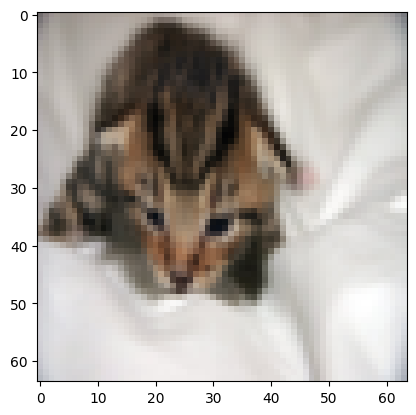

In [96]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + test_set_classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")
print(d["Y_prediction_test"][0, index])
print(test_set_classes[int(d["Y_prediction_test"][0, index])])

Let's also plot the cost function and the gradients.

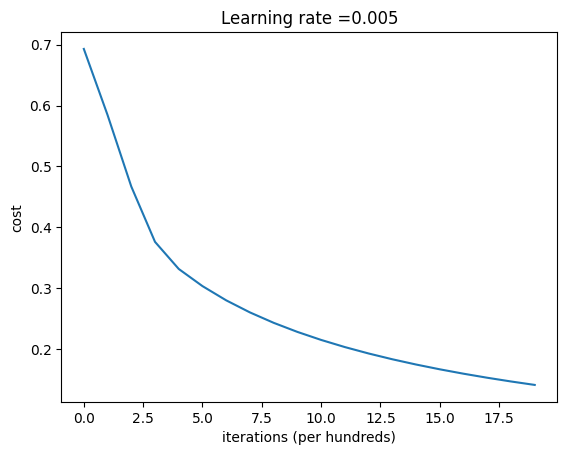

In [97]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## 6 - Further analysis (optional/ungraded exercise) ##

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

learning rate is: 0.01
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.823921
Cost after iteration 200: 0.418944
Cost after iteration 300: 0.617350
Cost after iteration 400: 0.522116
Cost after iteration 500: 0.387709
Cost after iteration 600: 0.236254
Cost after iteration 700: 0.154222
Cost after iteration 800: 0.135328
Cost after iteration 900: 0.124971
Cost after iteration 1000: 0.116478
Cost after iteration 1100: 0.109193
Cost after iteration 1200: 0.102804
Cost after iteration 1300: 0.097130
Cost after iteration 1400: 0.092043
train accuracy: 99.52153110047847%
test accuracy: 68.0%

-------------------------------------------------------

learning rate is: 0.005
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.24294

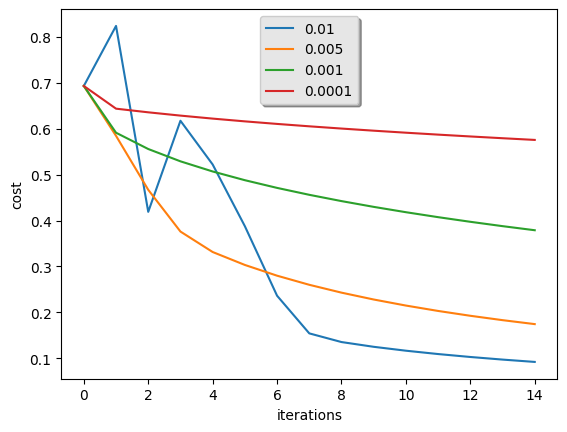

In [98]:
learning_rates = [0.01, 0.005, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 


## 7 - Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

y = 0, your algorithm predicts a "non-cat" picture.


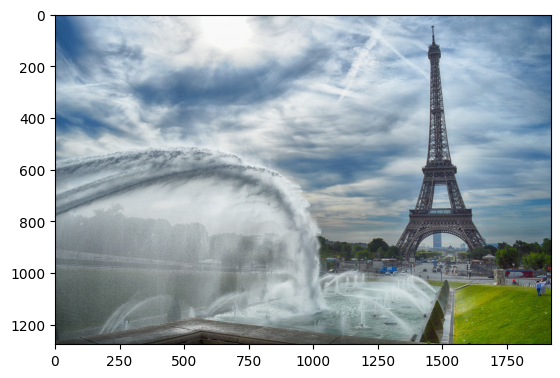

In [103]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "my_image.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
# 图像加载和预处理
fname = "images/" + my_image
image = imageio.v2.imread(fname)  # 读取图像，返回numpy数组

# 调整尺寸并预处理
# 处理灰度图像的情况（如果原始图像是灰度图）
if len(image.shape) == 2:
    image = np.repeat(image[:, :, np.newaxis], 3, axis=2)  # 转换为3通道

# 使用skimage进行resize
processed_image = resize(image, (num_px, num_px),
                        anti_aliasing=True,  # 抗锯齿
                        preserve_range=True)  # 保持数值范围
# image = np.array(ndimage.imread(fname, flatten=False))
# my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
# 格式转换和归一化
processed_image = (processed_image.reshape((1, num_px*num_px*3)).T / 255).astype(np.float32)

my_predicted_image = predict(processed_image,d["w"], d["b"])

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + test_set_classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<font color='blue'>
**What to remember from this assignment:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings (center the data, or divide each row by its standard deviation)

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c